In [1]:
# import packages
import math
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

### 1. Metric Choice
> Which of the following metrics would you choose to measure for this experiment and why? For each metric you choose, indicate whether you would use it as an invariant metric or an evaluation metric. The practical significance boundary for each metric, that is, the difference that would have to be observed before that was a meaningful change for the business, is given in parentheses. All practical significance boundaries are given as absolute changes.


> Any place "unique cookies" are mentioned, the uniqueness is determined by day. (That is, the same cookie visiting on different days would be counted twice.) User-ids are automatically unique since the site does not allow the same user-id to enroll twice.


`Number of cookies`: That is, number of unique cookies to view the course overview page. (dmin=3000)

`Number of user-ids`: That is, number of users who enroll in the free trial. (dmin=50)

`Number of clicks`: That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). (dmin=240)

`Click-through-probability`: That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. (dmin=0.01)

`Gross conversion`: That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. (dmin= 0.01)

`Retention`: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. (dmin=0.01)

`Net conversion`: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. (dmin= 0.0075)

> You should also decide now what results you will be looking for in order to launch the experiment. Would a change in any one of your evaluation metrics be sufficient? Would you want to see multiple metrics all move or not move at the same time in order to launch? This decision will inform your choices while designing the experiment.

<B> I expect to see increase in net conversion and retention, not too huge decrease in number of user-ids and gross conversion. 

### evaluation metrics
* use:
    - retention: We want to see more people made up their mind to finish the course before enrollment, so we expect this metric to increase.
    - gross conversion: We want to track whether too many users not enrolling the course because the experiment may scare customers away from enrollment.
    - net conversion: the movement of number of user-ids to remain enrolled past the 14-day boundary is uncertain, since we expect number of people check out will reduce. If this metric increases, we can know that the proportion of people stay after 14-days increases.
    
    
    
* not use:
    - number of user-ids: This metric is more variable than gross conversion since the total amount might be affected by how many users come to our website during the time period.


### invariant metrics
* use:
    - Number of cookies: This metric should be very stable.

* not use:
    - Number of clicks: This metric may be affected by other experiments, such as course ranking.
    - Click-through-probability: This metric may be affected by other experiments, such as course ranking </B>

### 2. Measuring Variability
> This spreadsheet contains rough estimates of the baseline values for these metrics (again, these numbers have been changed from Udacity's true numbers).
https://docs.google.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0


> For each metric you selected as an evaluation metric, estimate its standard deviation analytically. Do you expect the analytic estimates to be accurate? That is, for which metrics, if any, would you want to collect an empirical estimate of the variability if you had time?

> one-sample SE:
![\Large SE=\sqrt{\frac{p*(1-p)}{n}](https://latex.codecogs.com/svg.latex?\Large&space;SE=\sqrt{\frac{p*(1-p)}{n}) 

> two-sample SE:
![\Large SE=\sqrt{p_p*(1-p_p)*(1/n_c+1/n_e)}](https://latex.codecogs.com/svg.latex?\Large&space;SE=\sqrt{p_p*(1-p_p)*(1/n_c+1/n_e)})

In [162]:
df_baseline = pd.read_excel('Final Project Baseline Values.xlsx', header=None)
df_baseline

,0,1
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109312


In [163]:
# given data
cookies_overview_per_day = df_baseline.iloc[0,1]
cookies_click_per_day = df_baseline.iloc[1,1]
enrollment_per_day = df_baseline.iloc[2,1]
click_through_probability = df_baseline.iloc[3,1]
enrollment_per_click = df_baseline.iloc[4,1]
payment_per_enrollment = df_baseline.iloc[5,1]
payment_per_click = df_baseline.iloc[6,1]

# assume 5000 cookies visiting course overview page
n = 5000

# Gross conversion: 
gross_conversion_se = math.sqrt(enrollment_per_click*(1-enrollment_per_click)/(n/40000*3200))
# Retention: 
retention_se = math.sqrt(payment_per_enrollment*(1-payment_per_enrollment)/(n/40000*660))
# Net conversion: 
net_conversion_se = math.sqrt(payment_per_click*(1-payment_per_click)/(n/40000*3200))

print(f"gross conversion variability: {gross_conversion_se}")
print(f"net conversion variability: {net_conversion_se}")
print(f"retention variability: {retention_se}")

gross conversion variability: 0.020230604137049392
net conversion variability: 0.015601544582488459
retention variability: 0.05494901217850908


<b> 
Analytic estimate of variability v.s. empirical estimate of the variability for each metric:
    - gross conversion: similar, since unit of diversion agrees with unit of analysis
    - retention: underestimated, since unit of diversion is smaller than unit of analysis
    - net conversion: similar, since unit of diversion agrees with unit of analysis
    
</b>

### 3. Sizing
*Choosing Number of Samples given Power*
> Using the analytic estimates of variance, how many pageviews total (across both groups) would you need to collect to adequately power the experiment? Use an alpha of 0.05 and a beta of 0.2. Make sure you have enough power for each metric.

In [164]:
def samplesize_ABtest(rA, dr, alpha, beta, sides):
    """
    return sample size for the AB test, 
    given 
    - baseline conversion rate rA 
    - required minimum difference dr = rB-rA,
    - significance level alpha
    - statistical power 1-beta
    """
    
    assert dr>1.e-20
    # conversion rate of B group
    rB = rA + dr
    
    zscore = stats.norm.isf(alpha)
    zpower = stats.norm.isf(beta)
    
    pooled_var = rA*(1-rA) + rB*(1-rB) # 2*r*(1-r)
    
    
    if sides ==2:  # two tailed
        zscore = stats.norm.isf(alpha/2)
        
    n12 = (zscore+zpower)**2 * pooled_var/ dr**2  
    return n12

In [165]:
# given data
gross_conversion_dmin = 0.01
retention_dmin = 0.01
net_conversion_dmin = 0.0075

In [166]:
# calculate baseline for evaluation metrics
gross_conversion_baseline = enrollment_per_day/cookies_click_per_day
retention_baseline = payment_per_enrollment
net_conversion_baseline = payment_per_click

In [167]:
# one unit of analysis needs how many pageviews
gross_conversion_pageview_factor = cookies_overview_per_day/cookies_click_per_day
retention_pageview_factor = cookies_overview_per_day/enrollment_per_day
net_conversion_pageview_factor = cookies_overview_per_day/cookies_click_per_day

In [168]:
# required sample size for each metric
gross_conversion_sample_size = samplesize_ABtest(rA=gross_conversion_baseline, dr=gross_conversion_dmin,
                                                 alpha=0.05, beta=0.2, sides=2)* \
                                gross_conversion_pageview_factor*2
retention_sample_size = samplesize_ABtest(retention_baseline, retention_dmin, 0.05, 0.2, 2)* \
                                retention_pageview_factor*2
net_conversion_sample_size = samplesize_ABtest(net_conversion_baseline, net_conversion_dmin, 0.05, 0.2, 2)* \
                                net_conversion_pageview_factor*2

print(f"sample size for gross conversion: {math.ceil(gross_conversion_sample_size)}")
print(f"sample size for retention: {math.ceil(retention_sample_size)}")
print(f"sample size for net conversion: {math.ceil(net_conversion_sample_size)}")

sample size for gross conversion: 653806
sample size for retention: 4733113
sample size for net conversion: 699530


In [169]:
# required sample size if we were to use Bonferroni
retention_sample_size = samplesize_ABtest(retention_baseline, retention_dmin, 0.05/3, 0.2, 2)* \
                                retention_pageview_factor*2
print(f"sample size for retention: {math.ceil(retention_sample_size)}")

sample size for retention: 6313194


<b>
Although net conversion and retention and gross conversion are correlated, making Bonferroni too conservative, I have two metrics to test at the same time and need to adjust the alpha accordingly.
</b>

*Choosing Duration vs. Exposure*
> What percentage of Udacity's traffic would you divert to this experiment (assuming there were no other experiments you wanted to run simultaneously)? Is the change risky enough that you wouldn't want to run on all traffic?


> Given the percentage you chose, how long would the experiment take to run, using the analytic estimates of variance? If the answer is longer than a few weeks, then this is unreasonably long, and you should reconsider an earlier decision.

In [170]:
# if we use all traffic, it will take 158 days to run the experiment, which is not practical
retention_duration = math.ceil(retention_sample_size/cookies_overview_per_day)
print(f"duration for testing retention with all traffic: {retention_duration} days")

duration for testing retention with all traffic: 158 days


In [171]:
# drop retention, we keep net conversion and gross conversion as evaluation metrics
net_conversion_sample_size = samplesize_ABtest(net_conversion_baseline, net_conversion_dmin, 0.05/2, 0.2, 2)* \
                                net_conversion_pageview_factor*2
net_conversion_duration = math.ceil(net_conversion_sample_size/cookies_overview_per_day)
print(f"duration for testing retention with all traffic: {net_conversion_duration} days")

duration for testing retention with all traffic: 22 days


<b>
It would take 158 days to run the experiment for retention and is beyond our bedget. I decide to go with only gross conversion and net conversion as evaluation metrics.
</b>

### 4. Analysis
> The data for you to analyze is here. This data contains the raw information needed to compute the above metrics, broken down day by day. Note that there are two sheets within the spreadsheet - one for the experiment group, and one for the control group.
https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0

The meaning of each column is:

`Pageviews`: Number of unique cookies to view the course overview page that day.

`Clicks`: Number of unique cookies to click the course overview page that day.

`Enrollments`: Number of user-ids to enroll in the free trial that day.

`Payments`: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)

*Sanity Checks*
> Start by checking whether your invariant metrics are equivalent between the two groups. If the invariant metric is a simple count that should be randomly split between the 2 groups, you can use a binomial test as demonstrated in Lesson 5. Otherwise, you will need to construct a confidence interval for a difference in proportions using a similar strategy as in Lesson 1, then check whether the difference between group values falls within that confidence level.


> If your sanity checks fail, look at the day by day data and see if you can offer any insight into what is causing the problem.

In [172]:
# load data
control_df = pd.read_excel('Final Project Results.xlsx', sheet_name='Control')
exp_df = pd.read_excel('Final Project Results.xlsx', sheet_name='Experiment')

In [173]:
# calculate confidence interval for one sample
def one_sample_test(p, n_cont, n_exp, alpha=0.05):
    se = math.sqrt(p*(1-p)/(n_cont+n_exp))
    z = stats.norm.ppf(1-alpha/2)
    m = z*se
    ci = (round(p-m, 4), round(p+m, 4))
    print(f"SE: {se}")
    print(f"margin of error: {m}")
    print(f"confidence interval: {ci}")
    return ci

In [174]:
# calculate confidence interval for two samples
def two_sample_test(p_pool, n_cont, n_exp, p_diff, alpha=0.05):
    se = math.sqrt(p_pool*(1-p_pool)*(1/n_cont+1/n_exp))
    z = stats.norm.ppf(1-alpha/2)
    m = z*se
    ci = (round(p_diff-m, 4), round(p_diff+m, 4))
    print(f"SE: {se}")
    print(f"margin of error: {m}")
    print(f"confidence interval: {ci}")
    return ci

In [175]:
# check whether observed value is between confidence interval
def whether_significant(observed, ci):
    return (observed < ci[1]) & (observed > ci[0]) != True

In [176]:
# check invariant variables over the entire experiment period
test_days = len(control_df)

# number of samples
n_pageview_cont = np.sum(control_df['Pageviews'][:test_days])
n_pageview_exp = np.sum(exp_df['Pageviews'][:test_days])
n_click_cont = np.sum(control_df['Clicks'][:test_days])
n_click_exp = np.sum(exp_df['Clicks'][:test_days])

# pooled click through rate
click_through_rate_pool = (n_click_cont+n_click_exp)/(n_pageview_cont+n_pageview_exp)

# observed control rate
pageview_cont = n_pageview_cont/(n_pageview_exp+n_pageview_cont)
click_cont = n_click_cont/(n_click_exp+n_click_cont)
click_through_rate_cont = n_click_cont/n_pageview_cont
click_through_rate_exp = n_click_exp/n_pageview_exp
click_through_rate_obs = click_through_rate_exp - click_through_rate_cont

# sanity check for pageview
print('sanity check for pageview')
pageview_ci = one_sample_test(p=0.5, n_cont=n_pageview_cont, n_exp=n_pageview_exp, alpha=0.05)
print(f"observed: {round(pageview_cont, 4)}")
print(f"significant: {whether_significant(pageview_cont, pageview_ci)}")

# sanity check for click
print('\nsanity check for click')
click_ci = one_sample_test(p=0.5, n_cont=n_click_cont, n_exp=n_click_exp, alpha=0.05)
print(f"observed: {round(click_cont, 4)}")
print(f"significant: {whether_significant(click_cont, click_ci)}")

# sanity check for click through rate
print('\nsanity check for click through rate')
ctr_ci = two_sample_test(p_pool=click_through_rate_pool, n_cont=n_pageview_cont, n_exp=n_pageview_exp, p_diff=0, alpha=0.05)
print(f"observed: {round(click_through_rate_obs, 4)}")
print(f"significant: {whether_significant(click_through_rate_obs, ctr_ci)}")

sanity check for pageview
SE: 0.0006018407402943247
margin of error: 0.0011795861754058006
confidence interval: (0.4988, 0.5012)
observed: 0.5006
significant: False

sanity check for click
SE: 0.002099747079699252
margin of error: 0.004115428652853688
confidence interval: (0.4959, 0.5041)
observed: 0.5005
significant: False

sanity check for click through rate
SE: 0.0006610608156387222
margin of error: 0.001295655390242568
confidence interval: (-0.0013, 0.0013)
observed: 0.0001
significant: False


*Check for Practical and Statistical Significance*
> Next, for your evaluation metrics, calculate a confidence interval for the difference between the experiment and control groups, and check whether each metric is statistically and/or practically significance. A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary (that is, you can be confident there is a change that matters to the business.)


> If you have chosen multiple evaluation metrics, you will need to decide whether to use the Bonferroni correction. When deciding, keep in mind the results you are looking for in order to launch the experiment. Will the fact that you have multiple metrics make those results more likely to occur by chance than the alpha level of 0.05?

In [177]:
# use all experiment data
test_days = 23

# number of samples
n_click_cont = np.sum(control_df['Clicks'][:test_days])
n_click_exp = np.sum(exp_df['Clicks'][:test_days])
n_enrollment_cont = np.sum(control_df['Enrollments'][:test_days])
n_enrollment_exp = np.sum(exp_df['Enrollments'][:test_days])
n_payment_cont = np.sum(control_df['Payments'][:test_days])
n_payment_exp = np.sum(exp_df['Payments'][:test_days])

# pooled click through rate
gross_conversion_pool = (n_enrollment_cont+n_enrollment_exp)/(n_click_cont+n_click_exp)
net_conversion_pool = (n_payment_cont+n_payment_exp)/(n_click_cont+n_click_exp)

# gross conversion rate
gross_conversion_cont = (n_enrollment_cont)/(n_click_cont)
gross_conversion_exp = (n_enrollment_exp)/(n_click_exp)
gross_conversion_d = gross_conversion_exp - gross_conversion_cont
gross_conversion_dmin = 0.01

# net conversion rate
net_conversion_cont = (n_payment_cont)/(n_click_cont)
net_conversion_exp = (n_payment_exp)/(n_click_exp)
net_conversion_d = net_conversion_exp - net_conversion_cont
net_conversion_dmin = 0.0075

# test for gross conversoin difference (with Bonferroni correction)
print("test for gross conversoin difference")
gross_conversoin_ci = two_sample_test(p_pool=gross_conversion_pool, n_cont=n_click_cont, n_exp=n_click_exp, p_diff=gross_conversion_d, alpha=0.05/2)
print(f"observed difference: {gross_conversion_d}")
print(f"statistically significant: {whether_significant(0, gross_conversoin_ci)}")
print(f"pratically significant: {whether_significant(-gross_conversion_dmin, gross_conversoin_ci)}")

# test for net conversoin difference (with Bonferroni correction)
print("\ntest for net conversoin difference")
net_conversoin_ci = two_sample_test(p_pool=net_conversion_pool, n_cont=n_click_cont, n_exp=n_click_exp, p_diff=net_conversion_d, alpha=0.05/2)
print(f"observed difference: {net_conversion_d}")
print(f"statistically significant: {whether_significant(0, net_conversoin_ci)}")
print(f"pratically significant: {whether_significant(-net_conversion_dmin, net_conversoin_ci)}")


test for gross conversoin difference
SE: 0.004371675385225936
margin of error: 0.00979868513264882
confidence interval: (-0.0304, -0.0108)
observed difference: -0.020554874580361565
statistically significant: True
pratically significant: True

test for net conversoin difference
SE: 0.0034341335129324238
margin of error: 0.007697276222846293
confidence interval: (-0.0126, 0.0028)
observed difference: -0.0048737226745441675
statistically significant: False
pratically significant: False


<b>
    Gross conversion is significantly lower in experiment, while the result of net conversion is insignificant
</b>

##### Run Sign Tests
> For each evaluation metric, do a sign test using the day-by-day breakdown. If the sign test does not agree with the confidence interval for the difference, see if you can figure out why.
Link for sign test: https://www.graphpad.com/quickcalcs/binomial1.cfm

In [178]:
# create gross conversion column
control_df['gross_conversion'] = control_df['Enrollments']/control_df['Clicks']
exp_df['gross_conversion'] = exp_df['Enrollments']/exp_df['Clicks']
gross_conversion_success_days = np.sum(np.array(exp_df['gross_conversion'] < control_df['gross_conversion'])[:test_days])
print(f"gross conversion success days: {gross_conversion_success_days}")

# create net conversion column
control_df['net_conversion'] = control_df['Payments']/control_df['Clicks']
exp_df['net_conversion'] = exp_df['Payments']/exp_df['Clicks']
net_conversion_success_days = np.sum(np.array(exp_df['net_conversion'] > control_df['net_conversion'])[:test_days])
print(f"net conversion success days: {net_conversion_success_days}")


gross conversion success days: 19
net conversion success days: 10


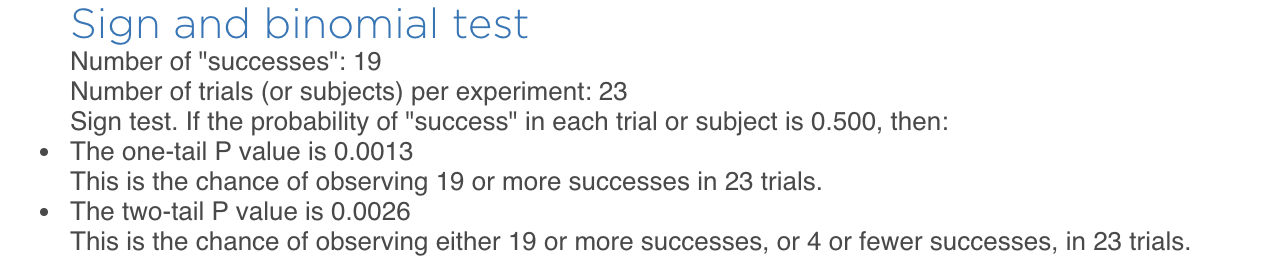

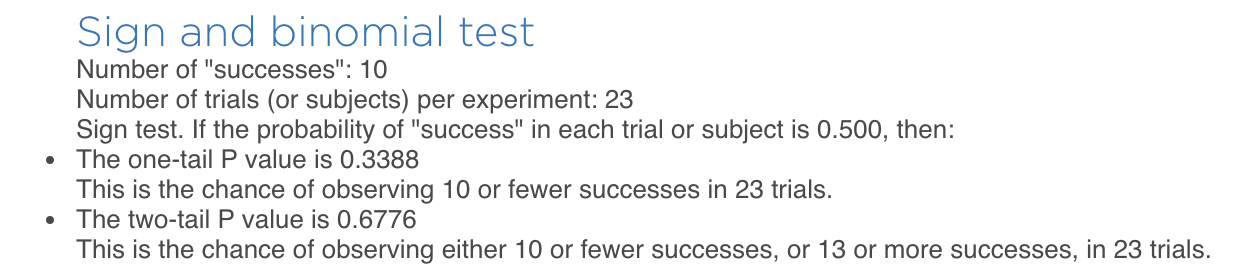

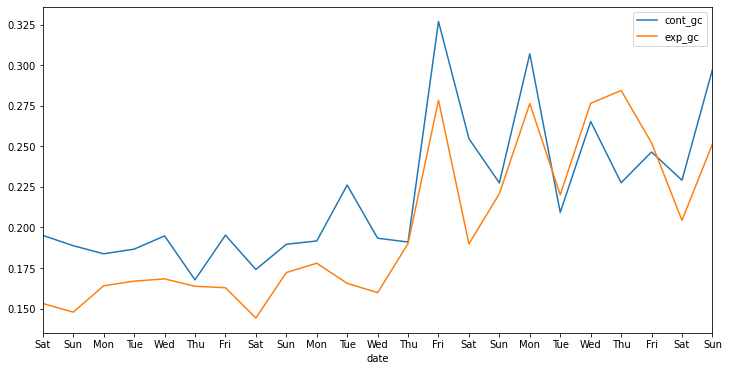

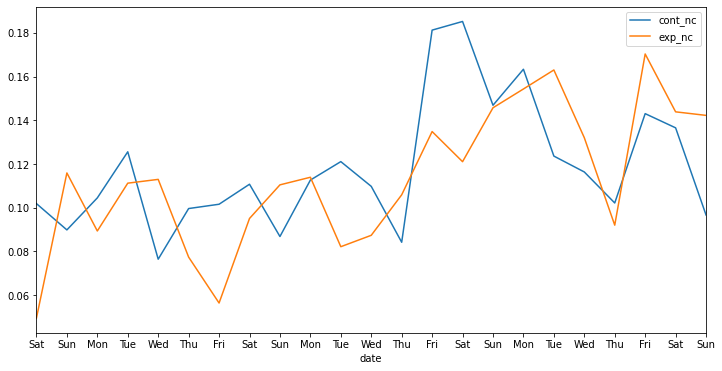

In [236]:
# plot to compare the metrics
# create a combined df for plotting
total_df = pd.DataFrame({'date': control_df['Date'],
                         'cont_gc': control_df['gross_conversion'], 'exp_gc': exp_df['gross_conversion'],
                         'cont_nc': control_df['net_conversion'], 'exp_nc': exp_df['net_conversion']})

# drop records without important metrics
total_df = total_df.dropna()

# convert date column to datetime for plotting
total_df['date'] = pd.to_datetime(total_df['date'], format='%a, %b %d')

# plot gross conversion over experiment period
ax = total_df.plot(x='date', y=['cont_gc', 'exp_gc'], figsize=(12,6))
# adjust tick to show weekday
ticks = list(total_df['date'])
labels = "Sat Sun Mon Tue Wed Thu Fri".split()
plt.xticks(ticks, labels*3 + ['Sat', 'Sun'])
plt.show()

# plot net conversion over experiment period
ax = total_df.plot(x='date', y=['cont_nc', 'exp_nc'], figsize=(12,6))
# adjust tick to show weekday
ticks = list(total_df['date'])
labels = "Sat Sun Mon Tue Wed Thu Fri".split()
plt.xticks(ticks, labels*3 + ['Sat', 'Sun'])
plt.show()

<b>
    Based on the sign test, gross conversion is still significantly lower in experiment, while the result of net conversion is insignificant. However, taking a closer look, we can see net conversion rate is higher in experiment on Sunday (3 out of 4 and 1 is very close). Although it's still not significant in sign test, we can bear this in mind if we have a longer experiment in the future and see if the effect will be significant.
</b>

*Make a Recommendation*
> Finally, make a recommendation. Would you launch this experiment, not launch it, dig deeper, run a follow-up experiment, or is it a judgment call? If you would dig deeper, explain what area you would investigate. If you would run follow-up experiments, briefIy describe that experiment. If it is a judgment call, explain what factors would be relevant to the decision.



<b>We cannot make conclusion about whether to launch the experiment because we lack the information about retention rate, which is the most important metric in this scenario. For this experiment, we expected to see less users drop out during the free trial. However, in the meantime, the experiment would cause less users to sign up for the free trial. 
    
Based on the experiment results, we did see significant decrease in the proportion of users to sign up for the free trial (gross conversion). If we saw significant increase in net conversion rate, we could conclude that the porportion of users to stay over the free trial increases. However, that is not the case. The result of net conversion rate is insignificantly lower. Thus, we need retention rate to determine whether higher proportion of users stay over the free trial. 
\begin{equation}
netconversion = payment/click = payment/enrollment * enrollment/click = retention * grossconversion
\end{equation}


Therefore, I would suggest to do more assessment about the outcome of this experiment (how much revenue increase if a user makes up his mind to finish the course v.s. how much revenue decrease if a user who would stay over the free trial is scared away), so we can determine whether conducting the complete experiment on the retention rate will worth it.
</b>